In [1]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/CommonSwissBirds

/content/drive/MyDrive/CommonSwissBirds


In [4]:
%ls

01_data_prep/  03_base_model/  05_efficientNetV2L/   readme.ipynb
02_data/       04_resnet_50/   06_mobileNetV3_mini/  utils/


In [5]:
sys.path.append('./utils')
import utils

In [6]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: Tesla T4 (UUID: GPU-dca177c6-6a58-37af-027c-ac59fbb830bc)


In [7]:
class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


In [9]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 5000 files belonging to 10 classes.
Using 1000 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/test_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
)

Found 1222 files belonging to 10 classes.


In [11]:
showcase_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/showcase_images',
    labels='inferred',
    label_mode='int',
    class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube'],
    color_mode='rgb',
    shuffle=False,
    batch_size=30,
    image_size=(224, 224),
)

Found 30 files belonging to 10 classes.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
showcase_ds = showcase_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
base_model = MobileNetV3Small(weights='imagenet', include_top=False, minimalistic=True)
model = utils.recompile_custom_output(base_model)

2128592/2128592 [==============================] - 1s 0us/step


In [14]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./06_mobileNetV3_mini/model/best.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [15]:
# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks],
)

Epoch 1/50
125/125 [==============================] - 766s 6s/step - loss: 0.7909 - accuracy: 0.7458 - val_loss: 0.4439 - val_accuracy: 0.8530
Epoch 2/50
125/125 [==============================] - 3s 25ms/step - loss: 0.2847 - accuracy: 0.9022 - val_loss: 0.2855 - val_accuracy: 0.9110
Epoch 3/50
125/125 [==============================] - 3s 22ms/step - loss: 0.1604 - accuracy: 0.9490 - val_loss: 0.2842 - val_accuracy: 0.9130
Epoch 4/50
125/125 [==============================] - 2s 20ms/step - loss: 0.1013 - accuracy: 0.9700 - val_loss: 0.3730 - val_accuracy: 0.9000
Epoch 5/50
125/125 [==============================] - 3s 21ms/step - loss: 0.0795 - accuracy: 0.9785 - val_loss: 0.1725 - val_accuracy: 0.9540
Epoch 6/50
125/125 [==============================] - 2s 20ms/step - loss: 0.0578 - accuracy: 0.9870 - val_loss: 0.1890 - val_accuracy: 0.9480
Epoch 7/50
125/125 [==============================] - 2s 20ms/step - loss: 0.0427 - accuracy: 0.9895 - val_loss: 0.3173 - val_accuracy: 0.9120

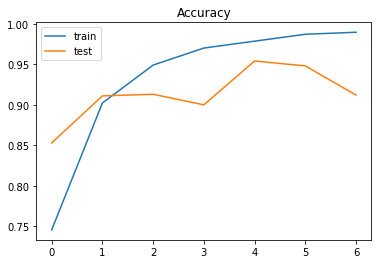

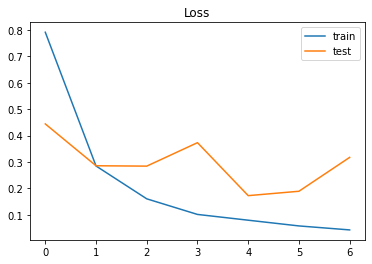

In [16]:
%matplotlib inline
utils.plot_history(history)

In [17]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./06_mobileNetV3_mini/model/best_finetuned.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [18]:
for layer in base_model.layers:
    layer.trainable = True

# recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again 
histroy = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks]
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


125/125 [==============================] - 11s 57ms/step - loss: 0.4954 - accuracy: 0.8690 - val_loss: 0.2720 - val_accuracy: 0.9260
Epoch 2/50
125/125 [==============================] - 6s 52ms/step - loss: 0.2093 - accuracy: 0.9327 - val_loss: 0.2242 - val_accuracy: 0.9380
Epoch 3/50
125/125 [==============================] - 7s 55ms/step - loss: 0.1372 - accuracy: 0.9555 - val_loss: 0.2048 - val_accuracy: 0.9410
Epoch 4/50
125/125 [==============================] - 6s 51ms/step - loss: 0.1000 - accuracy: 0.9665 - val_loss: 0.1909 - val_accuracy: 0.9520
Epoch 5/50
125/125 [==============================] - 7s 56ms/step - loss: 0.0766 - accuracy: 0.9772 - val_loss: 0.1797 - val_accuracy: 0.9540
Epoch 6/50
125/125 [==============================] - 6s 50ms/step - loss: 0.0616 - accuracy: 0.9845 - val_loss: 0.1705 - val_accuracy: 0.9510
Epoch 7/50
125/125 [==============================] - 6s 50ms/step - loss: 0.0513 - accuracy: 0.9902 - val_loss: 0.1628 - val_accuracy: 0.9520


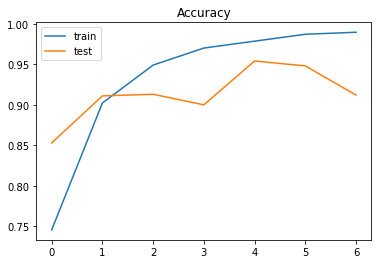

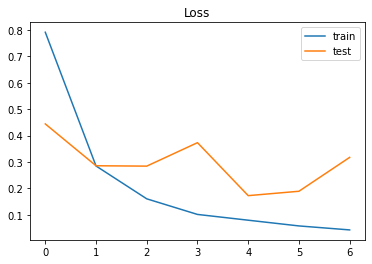

In [19]:
%matplotlib inline
utils.plot_history(history)

In [20]:
# Possible to start here without training... just loading the new weights...
base_model = MobileNetV3Small(weights='imagenet', include_top=False, minimalistic=True)
model = utils.recompile_custom_output(base_model)
model.load_weights('./06_mobileNetV3_mini/model/best_finetuned.h5')

In [21]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
39/39 [==============================] - 198s 5s/step - loss: 0.4464 - accuracy: 0.8863
test loss, test acc: [0.4463663399219513, 0.8862520456314087]


In [22]:
testset_predictions = model.predict(test_ds)
predicted_labels = [prediction.argmax() for prediction in testset_predictions]
true_labels = utils.get_labels_from_categorical_batch_dataset(test_ds)
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

39/39 [==============================] - 1s 13ms/step


In [23]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       0.86      0.85      0.86       113
     blaumeise       0.90      0.90      0.90       125
      buchfink       0.92      0.87      0.89       125
        elster       0.92      0.96      0.94       113
hausrotschwanz       0.78      0.97      0.87       117
     hausspatz       0.87      0.80      0.83       133
     kohlmeise       0.88      0.90      0.89       125
   rabenkraehe       0.93      0.92      0.92       121
          star       0.92      0.91      0.92       125
  tuerkentaube       0.91      0.81      0.86       125

      accuracy                           0.89      1222
     macro avg       0.89      0.89      0.89      1222
  weighted avg       0.89      0.89      0.89      1222



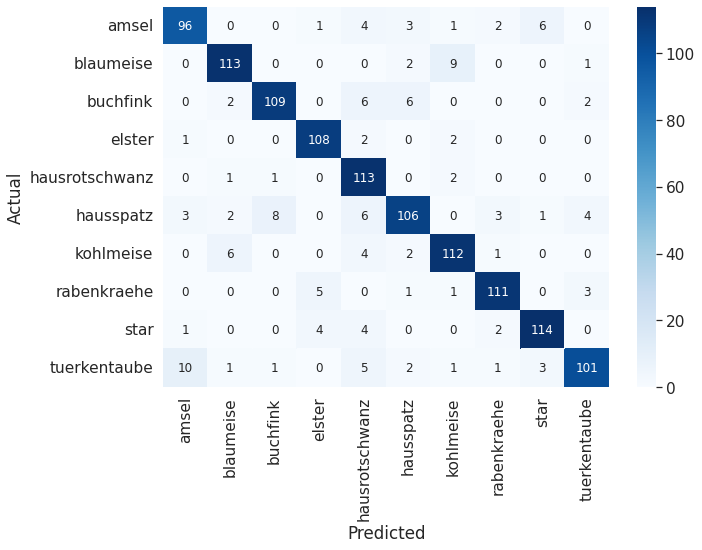

In [24]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

In [25]:
showcase_predictions = model.predict(showcase_ds)
predicted_labels = [prediction.argmax() for prediction in showcase_predictions]
true_labels = [label.numpy() for label in [labels for images, labels in showcase_ds.take(1)][0]]
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

1/1 [==============================] - 6s 6s/step


In [26]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       1.00      0.67      0.80         3
     blaumeise       1.00      1.00      1.00         3
      buchfink       1.00      1.00      1.00         3
        elster       0.75      1.00      0.86         3
hausrotschwanz       1.00      1.00      1.00         3
     hausspatz       1.00      1.00      1.00         3
     kohlmeise       1.00      1.00      1.00         3
   rabenkraehe       1.00      1.00      1.00         3
          star       0.67      0.67      0.67         3
  tuerkentaube       1.00      1.00      1.00         3

      accuracy                           0.93        30
     macro avg       0.94      0.93      0.93        30
  weighted avg       0.94      0.93      0.93        30



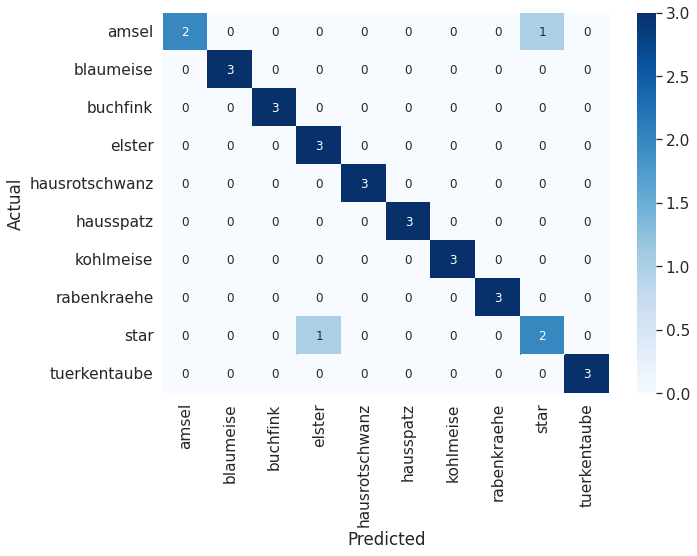

In [27]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

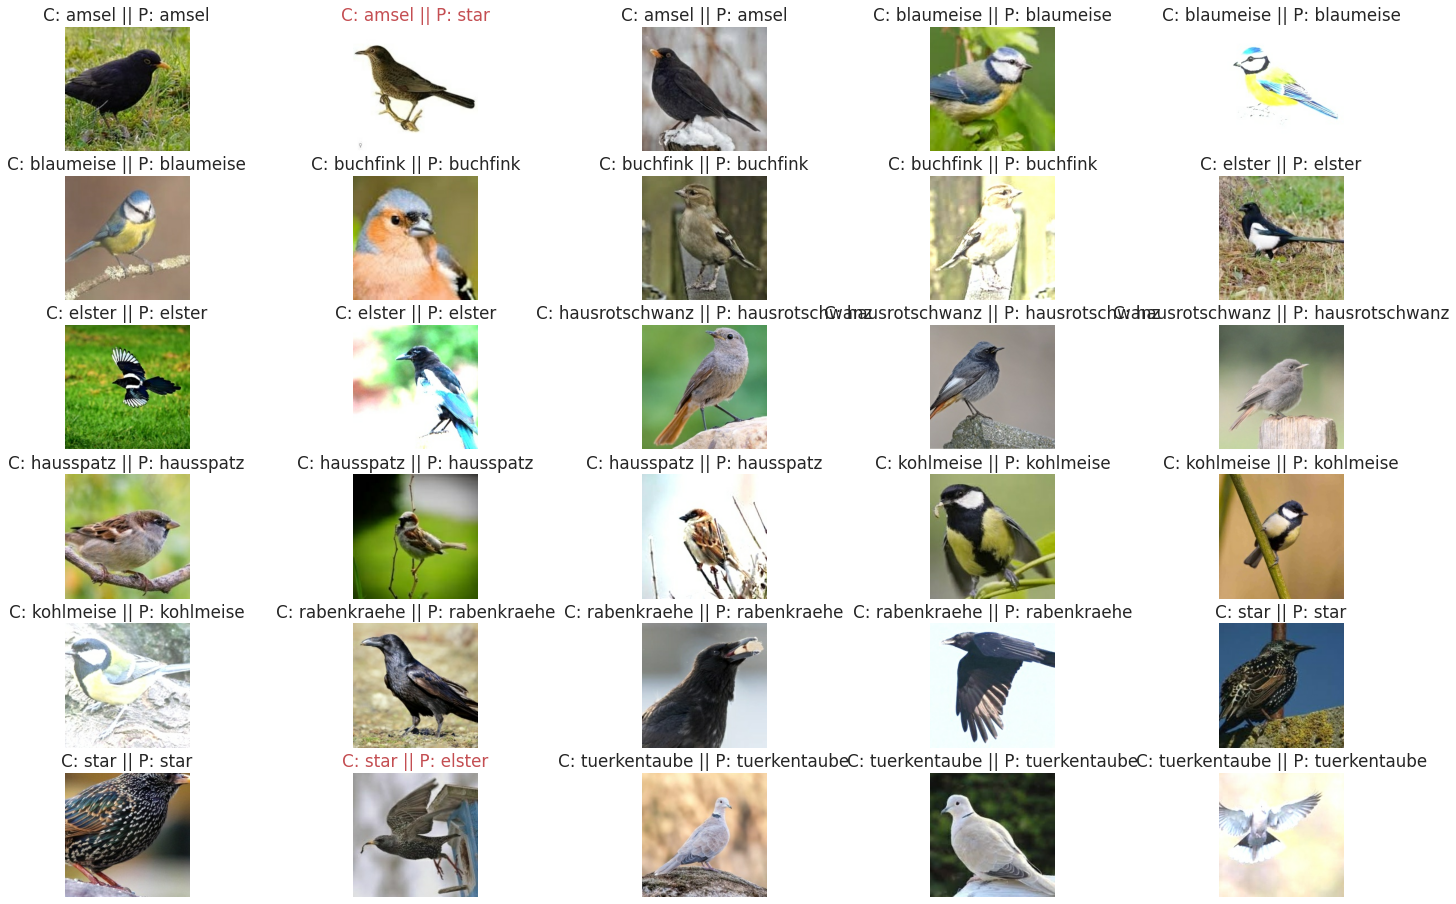

In [28]:
%matplotlib inline
utils.plot_showcase(showcase_ds, class_names, showcase_predictions)

# Grad-CAM
Showing important features of the image

Remarkable: Predictions can differ from batch predictions somehow. Here every image is predicted as as single item.

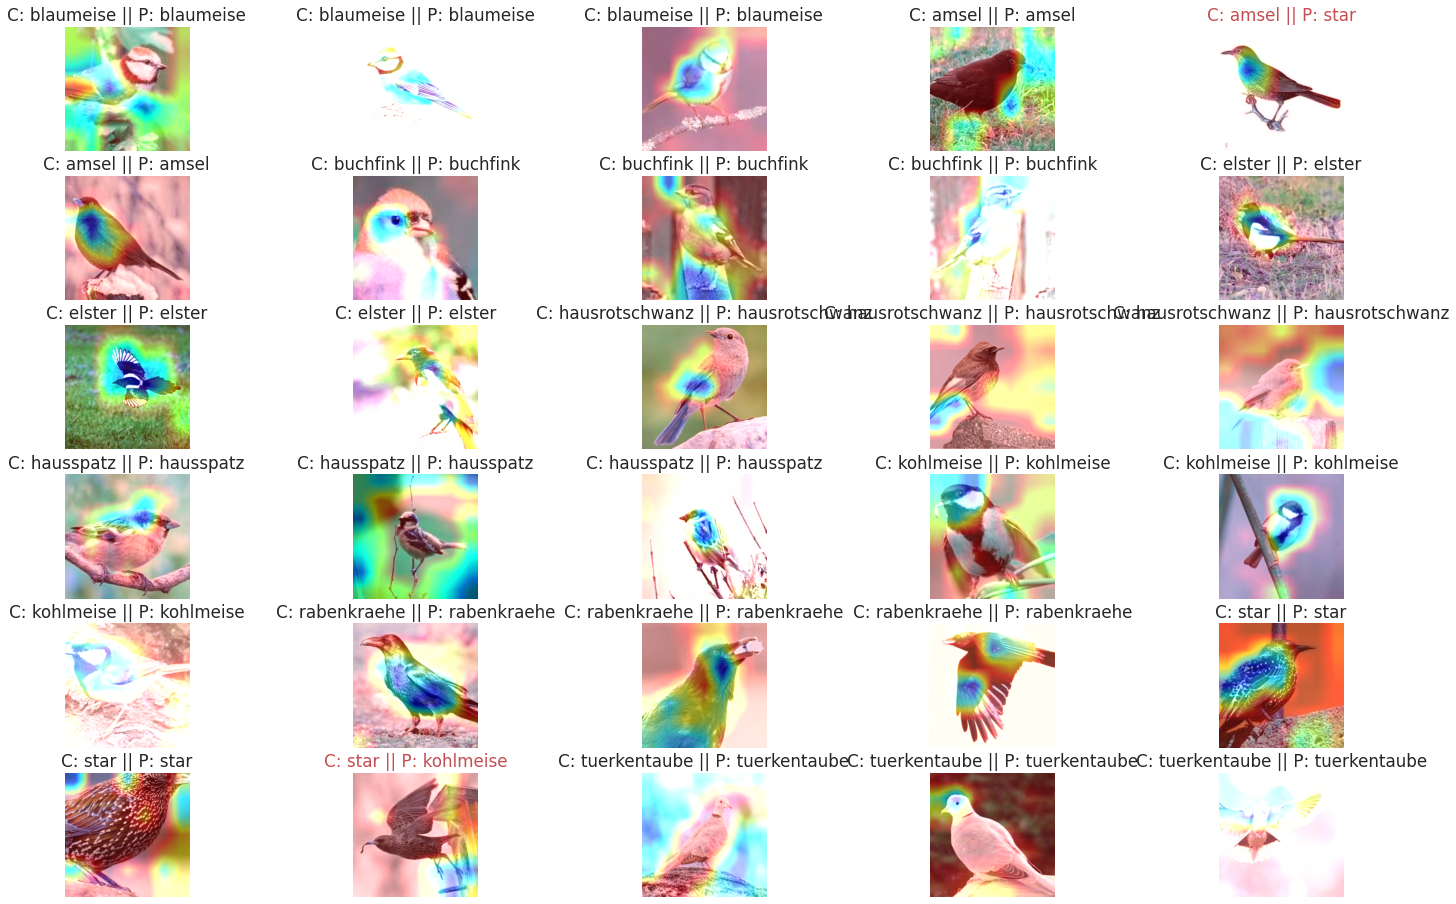

In [29]:
showcase_path = './02_data/99_dataset_preparation/showcase_images'
last_convolution_layer_name = 'Conv_1'
utils.plot_showcase_gradcam_overlay(showcase_path, class_names, model, last_convolution_layer_name)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling_1[0][0]']            
                                16)                                                         